In [78]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import warnings
from scipy.stats import skew
from statsmodels.stats.proportion import proportions_ztest # For proportion Z-test
from statsmodels.formula.api import ols      # For n-way ANOVA
from statsmodels.stats.anova import anova_lm # For n-way ANOVA
from   scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
insured = df.copy()

In [4]:
print("Rows",insured.shape[0])
print("Columns",insured.shape[1])
print("\nFeatures : \n",insured.columns.to_list())
print("\nMissing Values: \n",insured.isnull().sum().values.sum())
print("Unique Values : \n", insured.nunique())


Rows 1338
Columns 7

Features : 
 ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Missing Values: 
 0
Unique Values : 
 age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


In [5]:
insured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
insured['region'].unique().tolist()

['southwest', 'southeast', 'northwest', 'northeast']

In [7]:
insured['children'].unique().tolist()

[0, 1, 3, 2, 5, 4]

### Types of variables

Categorical varibles - sex,smoker,region,children

Quantitative variables -age,bmi,charges. Here children is a discrete variable where as age, bmi, and charges are continous variables.

There are no missing values

In [8]:
#changing object dtype to category  to save memory
insured.sex=insured['sex'].astype("category")
insured.smoker=insured['smoker'].astype("category")
insured.region=insured['region'].astype("category")

In [9]:
insured

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [10]:
insured.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### Observations

Average age of the primary beneficiary is 39.2 and maximum age is 64.

Average BMI is 30.66, that is out of normal BMI range, Maximum BMI is 53.13

Average medical costs billed to health insurance is 13270, median is 9382 and maximum is 63770

Median is less than mean in charges , indicating distrubution is postively skewed .

Customer on an average has 1 child.

For Age, BMI, children , mean is almost equal to median , suggesting data is normally distrubuted

In [11]:
#Are there more Male beneficary ?
# Are there more smoker ?
# which region has maximum , claims .?

insured.describe(include='category')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [12]:
# get counts of unique observations for each category variable
list_col = insured.select_dtypes(['category']).columns
# list_col
for i in range(len(list_col)):
    print(insured[list_col[i]].value_counts())


male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


### Observation 

676 male and 662 female, indicated sample has slightly more males than females

1064 nonsomker and 274 smoker, indicating sample has more nonsmokers.

Number of claims from customer who reside in southwest region is more compared to other regions

# Exploratory Data Analysis

#### Univariate Analysis

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def dist_box(data):
    Name = data.name.upper()
    fig,(ax_box,ax_dis)  =plt.subplots(2,1,gridspec_kw = {"height_ratios": (.25, .75)},figsize=(8, 5))
    mean = data.mean()
    median = data.median()
    mode=data.mode().tolist()[0]
    fig.suptitle("SPREAD OF DATA FOR "+ Name  , fontsize=18, fontweight='bold')
    sns.boxplot(x=data,showmeans=True, orient='h',color="violet",ax=ax_box)
    ax_box.set(xlabel='')
    sns.distplot(data,kde=False,color='blue',ax = ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    ax_dis.axvline(mode, color='y', linestyle='-',linewidth=2)
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})
    
    

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

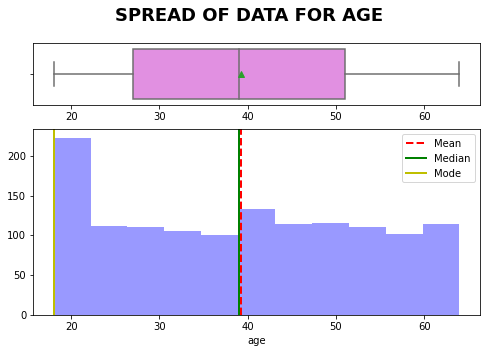

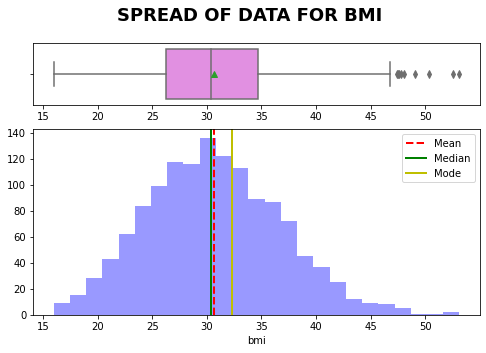

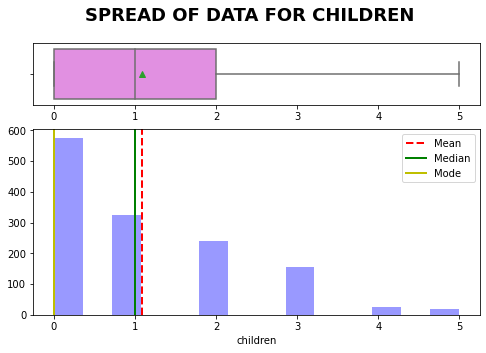

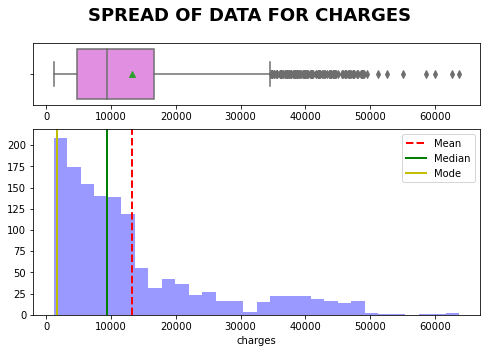

In [14]:
#select all quantitative columns for checking the spread
list_col = insured.select_dtypes([np.number]).columns
#select_dtypes([np.number]): selects all columns that are numeric (e.g., int, float)
for i in range(len(list_col)):
    dist_box(insured[list_col[i]])
warnings.filterwarnings("ignore")

#### Observations

Age of primary beneficary lies approximately between 20 - 65 . Average Age is aprrox. 40. Majority of customer are in range 18- 20's.

Bmi is normally distrubuted and Average BMI of beneficiary is 30.This BMI is outside the normal range of BMI. There are lot of outliers at upper end

Most of the beneficary have no childrens.

Charges distrubution is unimodal and is right skewed .Average cost incured to the insurance is appro. 130000 and highest charge is 63770.There are lot of outliers at upper end.

In [15]:
# Function to create barplots that indicate percentage for each category.
def bar_perc(plot,feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width()/2 -0.05 # width of the plot
        y = p.get_y() + p.get_height() # height of the plot
        plot.annotate(percentage, (x, y), size = 12) # annotate the percentage

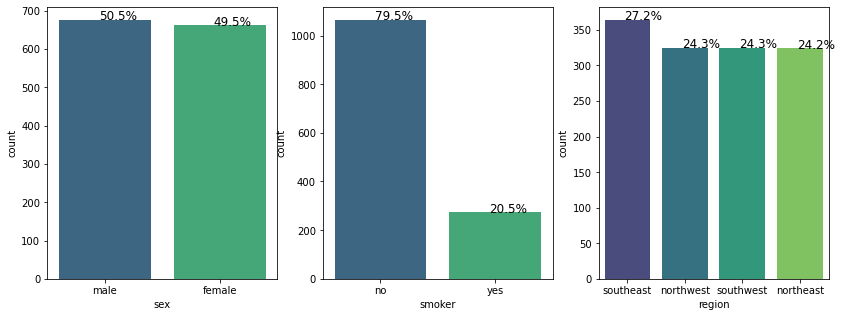

In [16]:
#get all category datatype 
# list_col = insured.select_dtypes(['category']).columns
# fig1, axes1 = plt.subplots(1,3,figsize =(14,5))
# for i in range(len(list_col)):
#     order = insured[list_col[i]].value_counts(ascending=False).index #to display bar in ascending order 
#     #Counts how many times each unique value appears in that column.
#     axis=sns.countplot(x=list_col[i], data=insured , order=order,ax=axes1[i],palette='viridis').set(title=list_col[i].upper())
#     bar_perc(axes1[i],insured[list_col[i]])

list_col = insured.select_dtypes(['category']).columns
fig1, axes1 = plt.subplots(1,3,figsize=(14,5))
for i in range(len(list_col)):
    order = insured[list_col[i]].value_counts(ascending=False).index #to display bar in ascending order 
    #Counts how many times each unique value appears in that column.
    axis = sns.countplot(x=list_col[i],data=insured,order=order,ax=axes1[i],palette='viridis')
    bar_perc(axes1[i],insured[list_col[i]])
    

#### Observations

50.5% of beneficiary are male and 49.5 % are female. Approximately same number of male and female beneficiary.

20.5% of beneficary are smokers.

Beneficary are evenly distributed across regions with South East being the most populous one (~27%) with the rest of regions each containing around ~24%

Most of the beneficiary don't have kid.

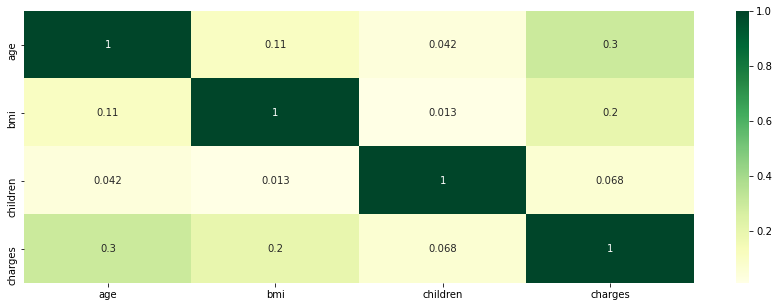

In [17]:
plt.figure(figsize=(15,5))
sns.heatmap(insured.corr(),annot=True ,cmap="YlGn" )
plt.show()

In [18]:
cat_columns=insured.select_dtypes(['category']).columns
cat_columns

Index(['sex', 'smoker', 'region'], dtype='object')

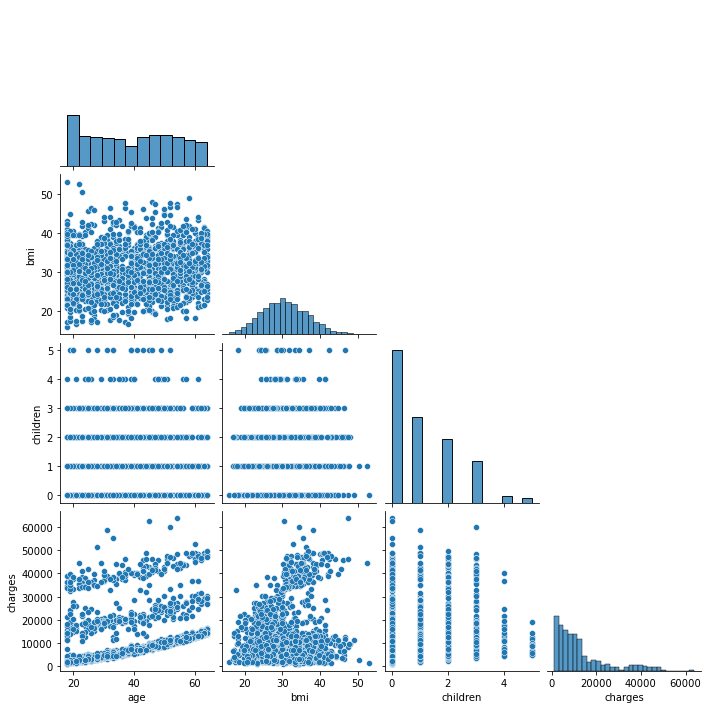

In [19]:
sns.pairplot(data=insured , corner=True)
plt.show()

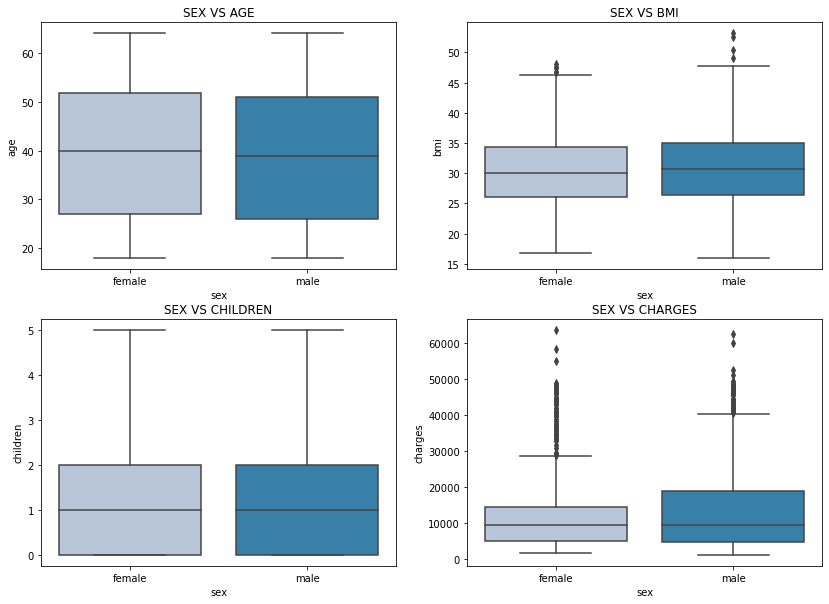

In [20]:
#sex vs all numerical variable
fig1 , axes1 = plt.subplots(2,2,figsize=(14,10))
#select all quantitative columns for checking the outliers
list_col = insured.select_dtypes([np.number]).columns
for i in range(len(list_col)):
    row = i//2
    columns = i%2
    ax= axes1[row,columns]
    sns.boxplot(x=insured['sex'],y=insured[list_col[i]],ax=ax,palette="PuBu", orient='v').set(title='SEX VS '+ list_col[i].upper())
    

#### Observation

Avergae Age of female beneficiary is slightly higher than male beneficiary

No of children both male and female beneficary have is same

BMI of Male policy holder has many outliers and Average BMI of male is slightly higher than female

Male policy holder has incure more charges to insurance compared to female policy holder. There are lot of outliers in female policy holder

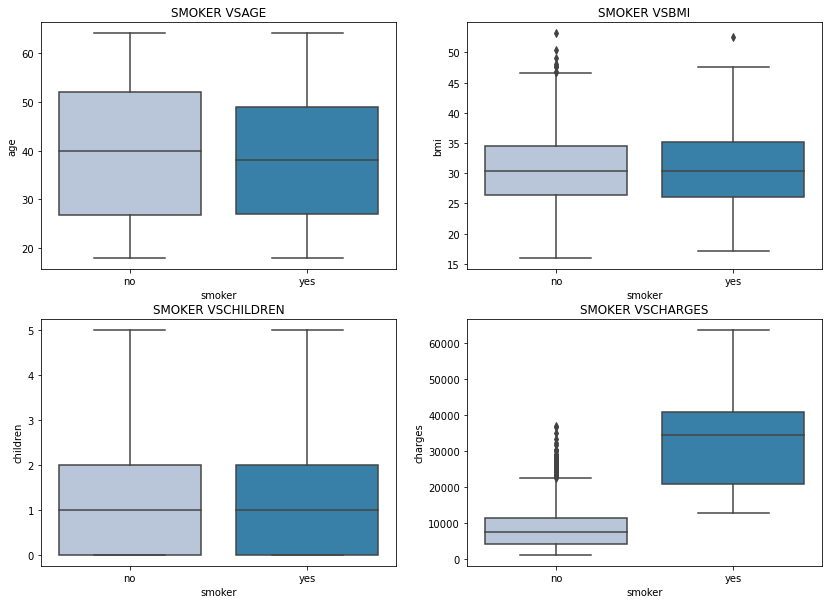

In [21]:
#smoker vs all numerical variable
fig1, axes1 = plt.subplots(2,2,figsize=(14,10))
list_col = insured.select_dtypes([np.number]).columns
for i in range(len(list_col)):
    row = i//2
    columns = i%2
    ax = axes1[row,columns]
    sns.boxplot(x=insured['smoker'], y=insured[list_col[i]],ax=ax,palette="PuBu",orient='v').set(title='SMOKER VS'+list_col[i].upper())

#### Observation

Smoker have incured more cost to insurance than nonsmoker. There are outliers in nonsmoker , need to analyze.

BMI of non smoker has lot of outliers.

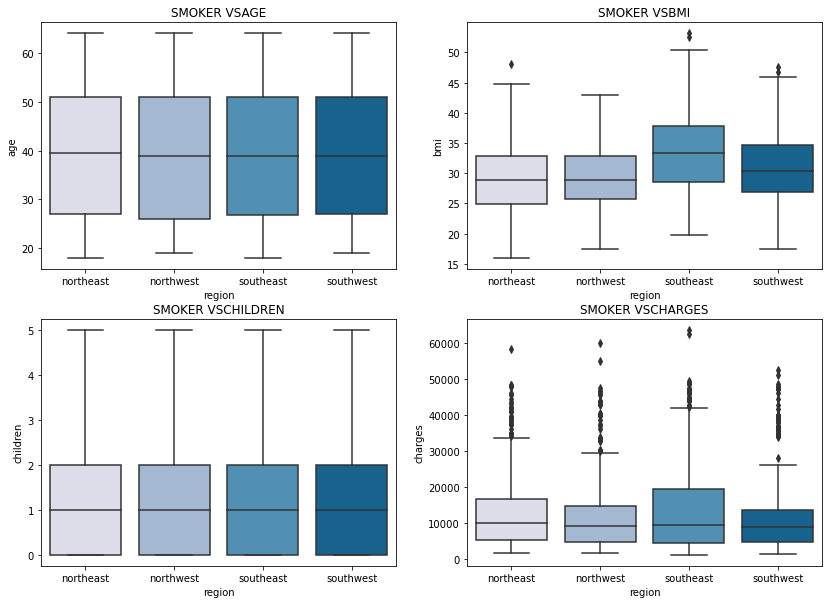

In [22]:
#region vs all numerical variable
fig1, axes1 = plt.subplots(2,2,figsize=(14,10))
list_col = insured.select_dtypes([np.number]).columns
for i in range(len(list_col)):
    row = i//2
    columns = i%2
    ax = axes1[row,columns]
    sns.boxplot(x=insured['region'], y=insured[list_col[i]],ax=ax,palette="PuBu",orient='v').set(title='SMOKER VS'+list_col[i].upper())

#### Observations

Age and numnber of children across regions is almost same.

Average Bmi of policy holder from southeast higher compared to other regions

Charges incured because of policy holder from southeast is higher compared to othe regions

There are lot of outliers on upper end in charges

In [23]:
# # Function to create barplots that indicate percentage for each category.
# def bar_perc(plot,feature):
#     total = len(feature)
#     for p in plot.patches:
#         percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
#         x = p.get_x() + p.get_width()/2 -0.05 # width of the plot
#         y = p.get_y() + p.get_height() # height of the plot
#         plot.annotate(percentage, (x, y), size = 12) # annotate the percentage

[Text(0.5, 1.0, 'Smoker vs Sex')]

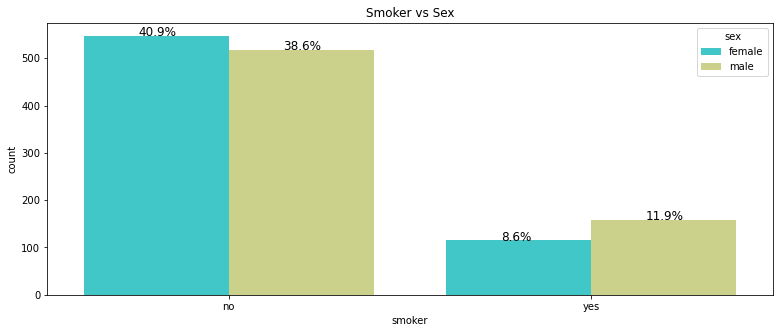

In [24]:
#smoker vs Sex
plt.figure(figsize=(13,5))
ax=sns.countplot(x='smoker',hue='sex',data=insured,palette='rainbow')
bar_perc(ax,insured['sex'])
ax.set(title="Smoker vs Sex")

[Text(0.5, 1.0, 'Smoker vs charges')]

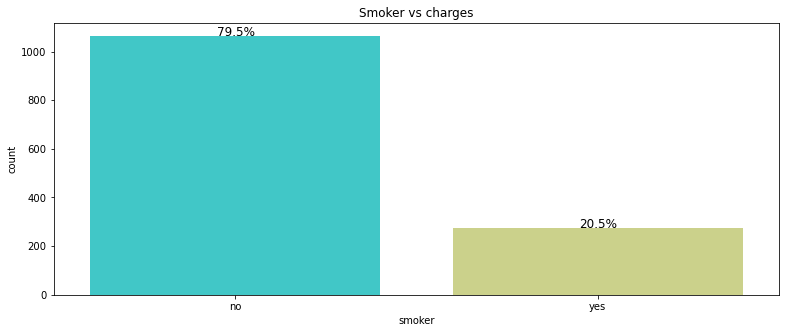

In [25]:
#smoker vs charges
plt.figure(figsize=(13,5))
ax=sns.countplot(x='smoker',data=insured,palette='rainbow')
bar_perc(ax,insured['charges'])
ax.set(title="Smoker vs charges")

[Text(0.5, 1.0, 'Smoker vs Region')]

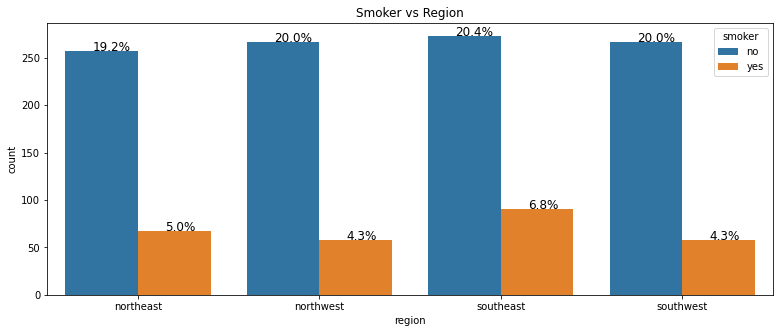

In [26]:
#region vs smoker
plt.figure(figsize=(13,5))
ax=sns.countplot(x='region',hue='smoker',data=insured)
bar_perc(ax,insured['smoker'])
ax.set(title="Smoker vs Region")

#### Observation

There are more male smokers than female.

Southeast region has more smokers

Smoker have more costlier claims than nonsmoker.

[Text(0.5, 1.0, 'Sex vs Region')]

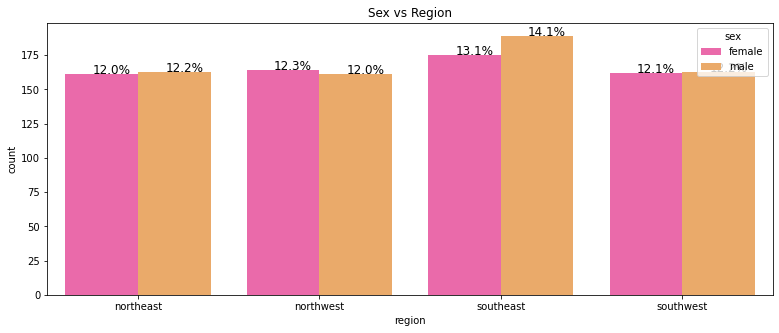

In [27]:
plt.figure(figsize=(13,5))
ax=sns.countplot(x='region',hue='sex',data=insured,palette='spring')
bar_perc(ax,insured['sex'])
ax.set(title="Sex vs Region")

# Observations

# There are more smokers in southeast region compared to other regions.

In [28]:
insured.groupby(insured['sex']).charges.mean()

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

[Text(0.5, 1.0, 'Sex Vs Charges')]

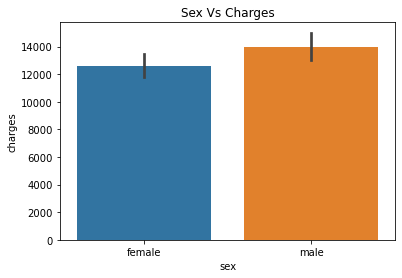

In [29]:
sns.barplot(x=insured.sex,y=insured.charges).set(title='Sex Vs Charges')

[Text(0.5, 1.0, 'Region Vs Charges')]

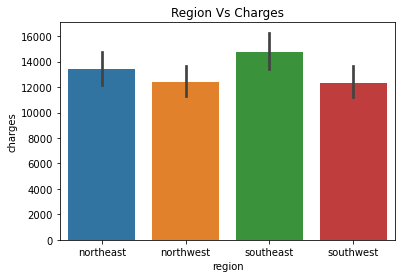

In [30]:
sns.barplot(x='region',y='charges',data=insured).set(title='Region Vs Charges')

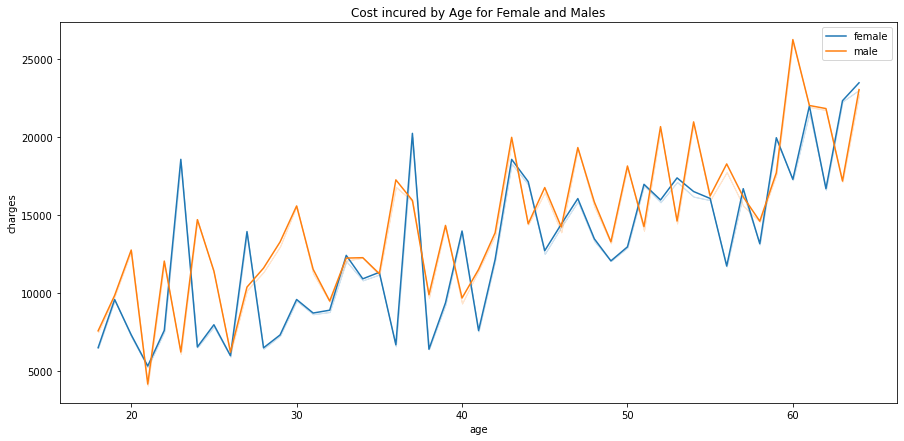

In [31]:
plt.figure(figsize=(15,7))
sns.lineplot(insured["age"],insured["charges"],hue=insured["sex"],ci=0).set(title= 'Cost incured by Age for Female and Males')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

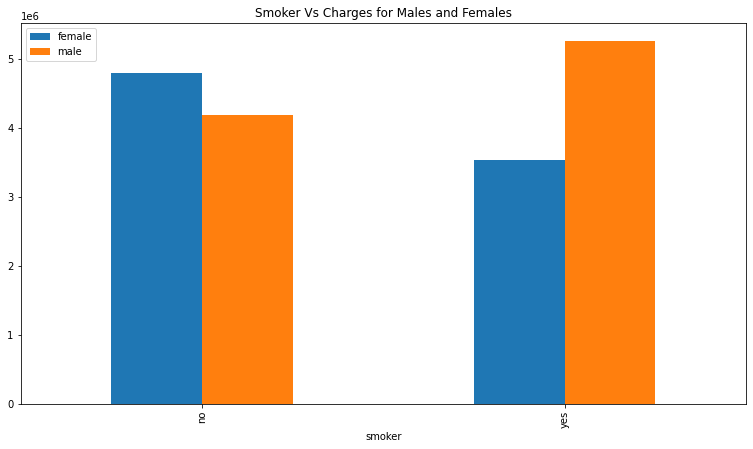

In [32]:
df_smoker_char_sex=pd.crosstab(index=insured.smoker,columns=insured.sex , values=insured.charges,aggfunc='sum')
fig1, axes1=plt.subplots(1,1,figsize=(13, 7))
df_smoker_char_sex.plot(kind='bar',ax=axes1,title="Smoker Vs Charges for Males and Females")
plt.legend(loc='upper left')
plt.show()

#### Observations

Charges incurred for males are more than charges incured for females

With increasing age of policy holder charges incured are going high for both male and female.

There some spikes for female at an approximate ages of 23,28,43.

Most claims are from southeast regions.

Males who smoke have most claims and have higher bills

Number of claims made by female who dont smoke is more compared to female who smoke.

In [33]:
#creating groups of bmi
category=pd.cut(insured.bmi,bins=[15,25,35,45,55],labels=['15-25','25-35','35-45','45-55'])
insured.insert(5,'BMIGroup',category)

In [34]:
insured.head()

,age,sex,bmi,children,smoker,BMIGroup,region,charges
0,19,female,27.900,0,yes,25-35,southwest,16884.92400
1,18,male,33.770,1,no,25-35,southeast,1725.55230
2,28,male,33.000,3,no,25-35,southeast,4449.46200
3,33,male,22.705,0,no,15-25,northwest,21984.47061
4,32,male,28.880,0,no,25-35,northwest,3866.85520


In [35]:
#no of children has no relation with charges
insured.groupby(insured.children).charges.mean()

children
0    12365.975602
1    12731.171832
2    15073.563734
3    15355.318367
4    13850.656311
5     8786.035247
Name: charges, dtype: float64

In [36]:
insured.groupby(insured.BMIGroup).charges.mean()

BMIGroup
15-25    10284.290025
25-35    12720.254311
35-45    16913.681515
45-55    17547.926750
Name: charges, dtype: float64

In [37]:
category1=pd.cut(insured.age,bins=[18,28,38,48,58,68],labels=['18-28','28-38','38-48','48-58','58-68'])
insured.insert(6,'AgeBin',category1)

In [38]:
insured.groupby(insured.AgeBin).charges.mean()

AgeBin
18-28     9528.142786
28-38    11598.554943
38-48    14334.585843
48-58    15887.954341
58-68    20824.972901
Name: charges, dtype: float64

In [39]:
insured.groupby(['region','sex','smoker']).charges.mean().unstack()

smoker                     no           yes
region    sex                              
northeast female  9640.426984  28032.046398
          male    8664.042222  30926.252583
northwest female  8786.998679  29670.824946
          male    8320.689321  30713.181419
southeast female  8440.205552  33034.820716
          male    7609.003587  36029.839367
southwest female  8234.091260  31687.988430
          male    7778.905534  32598.862854

[Text(0.5, 1.0, 'Age Vs Charges')]

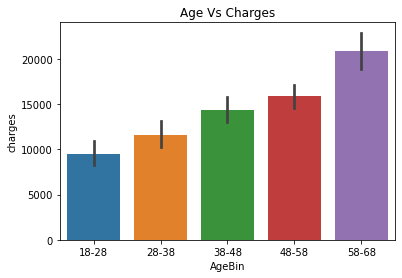

In [40]:
sns.barplot(x=insured.AgeBin,y=insured.charges).set(title='Age Vs Charges')

<AxesSubplot:xlabel='BMIGroup', ylabel='charges'>

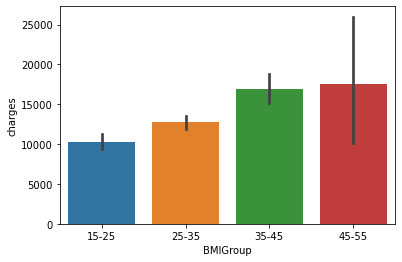

In [41]:
sns.barplot(x=insured.BMIGroup,y=insured.charges)

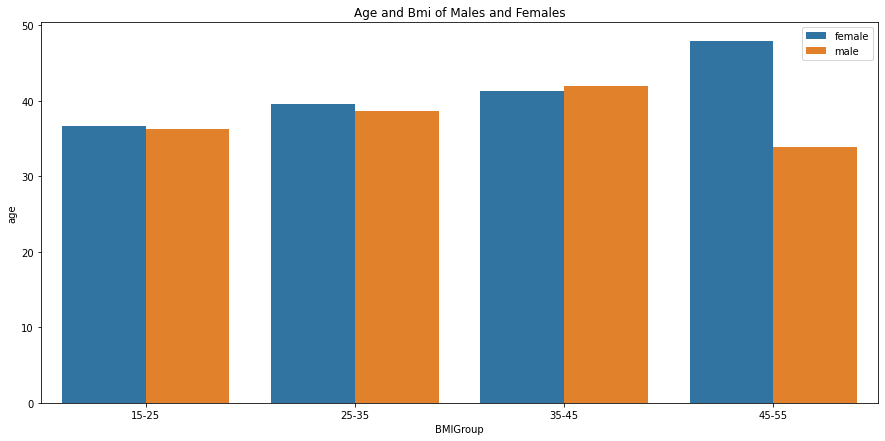

In [42]:
plt.figure(figsize=(15,7))
sns.barplot(x=insured["BMIGroup"],y=insured["age"],hue=insured['sex'],ci=0).set(title= 'Age and Bmi of Males and Females')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

[Text(0.5, 1.0, 'Fig 2:BMI group and Charges ')]

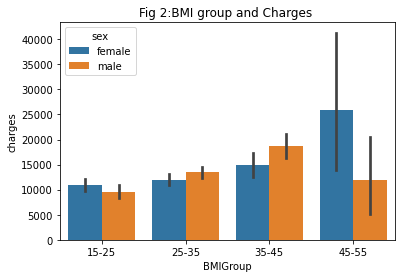

In [43]:
sns.barplot(x='BMIGroup',y='charges',hue='sex',data=insured).set(title="Fig 2:BMI group and Charges " )

#### Observations

FeMales with most BMI has incured most charges to the insurance company

BMI for male and females are not same

Beneficary with higher BMI have incurred more cost to insurance.

In [44]:
pd.crosstab(insured['sex'],insured['children'])

children,0,1,2,3,4,5
sex,,,,,,
female,289,158,119,77,11,8
male,285,166,121,80,14,10


#### Conclusion based on EDA

As expected , as the age of the beneficiary increases ,the cost to insurance increases.

Males who smoke have most claims and have higher bills.

Female who are nonsmoker also have more claims to nonsmoker males this may be because of child birth , need to explore claims type to understand better.

Beneficiary with 2 or 3 dependent have billed higher compared to others people who have 5.This is unusual and may be because of uneven number of observations in each group. For example, no dependents group has 574 observations whereas five dependents group only has 18.

Customer with bmi >30 are on higher side of obesity, have more health issues and have higher claims.

Females with BMI more than 45 have billed higher to insurance.

Age, BMI and Smoking are important attributes which can cost insurance company more.

## Statistical Analysis

### 1.Prove (or disprove) that the medical claims made by the people who smoke is greater than those who don't?

Step 1: Define null and alternative hypothesis
 
H0:The average charges of smokers is less than or equal to nonsmokers
 
Ha:The average charges of smokers is greater than nonsmokers


Step 2: Decide the significance level. If P values is less than alpha reject the null hypothesis.

α = 0.05


Step 3: Identify the test

Standard deviation of the population is not known ,will perform a T stat test . The > sign in alternate hypothesis indicate test is right tailed, that is all z values that would cause us to reject null hypothesis are in just one tail to the right of sampling distribution curve.

Step 4: Calculate the test-statistics and p-value

In [45]:
smoker=insured.loc[insured.smoker=="yes"]
smoker

,age,sex,bmi,children,smoker,BMIGroup,AgeBin,region,charges
0,19,female,27.900,0,yes,25-35,18-28,southwest,16884.92400
11,62,female,26.290,0,yes,25-35,58-68,southeast,27808.72510
14,27,male,42.130,0,yes,35-45,18-28,southeast,39611.75770
19,30,male,35.300,0,yes,35-45,28-38,southwest,36837.46700
23,34,female,31.920,1,yes,25-35,28-38,northeast,37701.87680
...,...,...,...,...,...,...,...,...,...
1313,19,female,34.700,2,yes,25-35,18-28,southwest,36397.57600
1314,30,female,23.655,3,yes,15-25,28-38,northwest,18765.87545
1321,62,male,26.695,0,yes,25-35,58-68,northeast,28101.33305
1323,42,female,40.370,2,yes,35-45,38-48,southeast,43896.37630


In [46]:
nonsmoker=insured.loc[insured.smoker=='no']
nonsmoker.head()

,age,sex,bmi,children,smoker,BMIGroup,AgeBin,region,charges
1,18,male,33.770,1,no,25-35,NaN,southeast,1725.55230
2,28,male,33.000,3,no,25-35,18-28,southeast,4449.46200
3,33,male,22.705,0,no,15-25,28-38,northwest,21984.47061
4,32,male,28.880,0,no,25-35,28-38,northwest,3866.85520
5,31,female,25.740,0,no,25-35,28-38,southeast,3756.62160


In [47]:
nonsmoker.count()

age         1064
sex         1064
bmi         1064
children    1064
smoker      1064
BMIGroup    1064
AgeBin      1007
region      1064
charges     1064
dtype: int64

In [48]:
# Adjusting the size of the rows to be equal
nonsmoker = nonsmoker.iloc[-274:]  # Use .iloc for DataFrame row slicing
charges_yes = smoker.charges
charges_no = nonsmoker.charges

In [50]:
nonsmoker

,age,sex,bmi,children,smoker,BMIGroup,AgeBin,region,charges
984,20,male,30.115,5,no,25-35,18-28,northeast,4915.05985
985,44,female,25.800,1,no,25-35,38-48,southwest,7624.63000
986,43,male,30.115,3,no,25-35,38-48,northwest,8410.04685
987,45,female,27.645,1,no,25-35,38-48,northwest,28340.18885
988,34,male,34.675,0,no,25-35,28-38,northeast,4518.82625
...,...,...,...,...,...,...,...,...,...
1332,52,female,44.700,3,no,35-45,48-58,southwest,11411.68500
1333,50,male,30.970,3,no,25-35,48-58,northwest,10600.54830
1334,18,female,31.920,0,no,25-35,NaN,northeast,2205.98080
1335,18,female,36.850,0,no,35-45,NaN,southeast,1629.83350


In [51]:
print('Average Cost charged to Insurance for smoker is {} and nonsmoker is {} '.format(charges_yes.mean(),charges_no.mean()))

Average Cost charged to Insurance for smoker is 32050.23183153285 and nonsmoker is 8441.24905576642 


[Text(0.5, 1.0, 'Fig:1 Smoker vs Charges')]

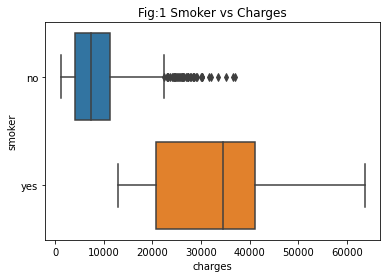

In [52]:
#smoker vs charges
sns.boxplot(x=insured.charges,y=insured.smoker,data=insured).set(title="Fig:1 Smoker vs Charges")

In [54]:
import scipy.stats as stats
alpha=0.05
t_statistic_1, p_value_1 = stats.ttest_ind(charges_yes, charges_no)
p_value_onetail=p_value_1/2

print("Test statistic = {} , Pvalue ={} , OnetailPvalue = {}".format(t_statistic_1,p_value_1, p_value_onetail ))

Test statistic = 30.168384427571915 , Pvalue =2.160499003168038e-118 , OnetailPvalue = 1.080249501584019e-118


In [56]:
if p_value_1 <alpha :
    print("Conclusion:Since P value {} is less than alpha {} ". format (p_value_onetail,alpha) )
    print("Reject Null Hypothesis that Average charges for smokers are less than or equal to nonsmoker.")
    
else:
    print("Conclusion:Since P value {} is greater than alpha {} ". format (p_value_onetail,alpha))
    print("Failed to Reject Null Hypothesis  and accept alternate hypothesis that Average charges for smokers are less than nonsmoker.")

Conclusion:Since P value 1.080249501584019e-118 is less than alpha 0.05 
Reject Null Hypothesis that Average charges for smokers are less than or equal to nonsmoker.


## 2.Prove (or disprove) with statistical evidence that the BMI of females is different from that of males.

Let  μ1,μ2 and be the respective population means for BMI of males and BMI of females

Step 1: Define null and alternative hypothesis

Ho : There is no difference between the BMI of Male and BMI of female. or Bmif = Bmim

Ha : There is difference between the BMI of Male and BMI of female.

In [58]:
#get all observation for male.
df_male = insured.loc[df['sex']=='male']
#get all observation for Female.
df_female = insured.loc[df['sex']=='female']

In [59]:
#get bmi of male and female
bmi_female=df_female['bmi']
bmi_male=df_male['bmi']

In [60]:
bmi_female

0       27.90
5       25.74
6       33.44
7       27.74
9       25.84
        ...  
1332    44.70
1334    31.92
1335    36.85
1336    25.80
1337    29.07
Name: bmi, Length: 662, dtype: float64

<AxesSubplot:xlabel='bmi', ylabel='Density'>

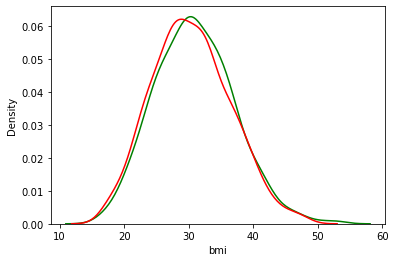

In [65]:
sns.distplot(bmi_male,color='green',hist=False)
sns.distplot(bmi_female,color='red',hist=False)

In [66]:
df_male['bmi'].mean()

30.943128698224832

In [67]:
df_female['bmi'].mean()

30.377749244713023

In [68]:
# get statistic and p value
t_stats , p_value = stats.ttest_ind(bmi_male,bmi_female)
print("tstats = ", t_stats, "P_value = ",p_value)

tstats =  1.696752635752224 P_value =  0.08997637178984932


In [70]:
alpha = 0.05

In [74]:
if p_value <alpha :
    print("Conclusion:Since P value {} is less than alpha {} ". format (p_value,alpha) )
    print("Reject Null Hypothesis and accept alternate hypothesis that There is difference between the BMI of Male and BMI of female..")
    
else:
    print("Conclusion:Since P value {} is greater than alpha {} ". format (p_value,alpha))
    print("Failed to Reject Null Hypothesis  that There is no difference between the BMI of Male and BMI of female. or Bmif = Bmim .")

Conclusion:Since P value 0.08997637178984932 is greater than alpha 0.05 
Failed to Reject Null Hypothesis  that There is no difference between the BMI of Male and BMI of female. or Bmif = Bmim .


## Is the proportion of smokers significantly different across different regions?

H0: Smokers proportions is not significantly different across different regions * 

Ha: Smokers proportions is different across different regions

In [75]:
contigency= pd.crosstab(insured.region, insured.smoker)
contigency

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


<AxesSubplot:xlabel='region'>

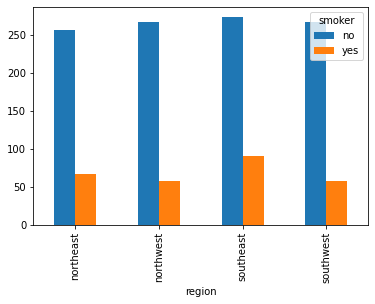

In [76]:
 contigency.plot(kind='bar')

In [79]:
chi2, pval, dof, exp_freq = chi2_contingency(contigency, correction = False)
print('chi-square statistic: {} , Pvalue: {} , Degree of freedom: {} ,expected frequencies: {} '.format(chi2, pval, dof, exp_freq))

chi-square statistic: 7.343477761407071 , Pvalue: 0.06171954839170541 , Degree of freedom: 3 ,expected frequencies: [[257.65022422  66.34977578]
 [258.44544096  66.55455904]
 [289.45889387  74.54110613]
 [258.44544096  66.55455904]] 


In [80]:
if (pval < 0.05):
    print('Reject Null Hypothesis')
else:
    print('Failed to reject Null Hypothesis')

Failed to reject Null Hypothesis


## Recommendation

Based on EDA and statistical evidence it can be seen that customer who smoke or have higher BMI have more higher claims.

We can encourage customers to quit smoking by providing them incentive points for talking to life coach, get help for improving lifestyle habits, Quit Tobacco- 28 day program. 

Give gift cards when customer accumulates specific number of points.

We can have Active wellness programs which can help up reduce claims related to BMI.

High BMI is primarily because of unhealthy life choices. We can provide customers with Diet plans and wellness health coaches which can help them to make right choices.

Provide discount coupons for Gym or fitness devices encouraging customers to exercise.